<a href="https://colab.research.google.com/github/NOWAYTE/EurekaBytes/blob/main/Data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Analysis

## Introduction

This report explains the code and results of the big data analytics tasks

# Data processing

The data was lodaded from a text file and processed using spark RDD. The data was filterred to only include rows where the HTTP methods was "GET"

!pip install pyspark
!pip show pyspark

In [2]:
# Initial Setup and Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("CN7031_BigDataAnalytics") \
    .config("spark.python.worker.timeout", "600") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

In [4]:
from google.colab import files

# This will prompt you to upload a file from your local system
uploaded = files.upload()

# This will display the uploaded file names
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


Saving apache_logs to apache_logs
Uploaded file: apache_logs


In [5]:
# 1. DF Creation with REGEX (10 marks)
# Custom schema definition
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# Define custom schema
custom_schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("ip", StringType(), True),
    StructField("method", StringType(), True),
    StructField("url", StringType(), True),
    StructField("status", IntegerType(), True)
])

# Read log file with REGEX pattern
log_pattern = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\d+)'

# Load data using the pattern

logs_df = spark.read.text("apache_logs") \
    .select(regexp_extract('value', log_pattern, 1).alias('ip'),
            regexp_extract('value', log_pattern, 4).alias('timestamp'),
            regexp_extract('value', log_pattern, 5).alias('method'),
            regexp_extract('value', log_pattern, 6).alias('url'),
            regexp_extract('value', log_pattern, 8).cast('integer').alias('status'))

# Register as temp view for SQL queries
logs_df.createOrReplaceTempView("logs")

logs_df.show()

+------------+--------------------+------+--------------------+------+
|          ip|           timestamp|method|                 url|status|
+------------+--------------------+------+--------------------+------+
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.149.9.216|17/May/2015:10:05...|   GET|/presentations/lo...|   200|
|83.14

### Advanced DF Analysis using SQL Window Functions

We perform advacned analysis using SQL window function to analyze traffic patters based on the IP addresses

In [6]:
# Ensure the 'timestamp' column is in the correct format
logs_df = logs_df.withColumn('timestamp', logs_df['timestamp'].cast('timestamp'))

# 1. **Window Function Analysis**
# Define window specification for counting traffic per IP over time
from pyspark.sql.window import Window
window_spec = Window.partitionBy('ip').orderBy('timestamp').rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Execute the window function query
traffic_analysis = spark.sql("""
    SELECT
        ip,
        timestamp,
        COUNT(*) OVER(PARTITION BY ip ORDER BY timestamp ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS hourly_traffic
    FROM logs
""")

# Show the results of the window function
traffic_analysis.show(5)

# 2. **Complex Aggregation**
# Perform a complex aggregation: daily and weekly traffic analysis
# Aggregate traffic per day and per week using SQL

daily_stats = spark.sql("""
    SELECT
        DATE(timestamp) AS date,
        COUNT(DISTINCT ip) AS unique_visitors
    FROM logs
    GROUP BY DATE(timestamp)
    ORDER BY date
""")

# Show results of daily traffic
daily_stats.show(5)

# Weekly traffic analysis: count the number of requests per week
weekly_stats = spark.sql("""
    SELECT
        YEAR(timestamp) AS year,
        WEEKOFYEAR(timestamp) AS week,
        COUNT(*) AS weekly_traffic
    FROM logs
    GROUP BY YEAR(timestamp), WEEKOFYEAR(timestamp)
    ORDER BY year, week
""")

# Show results of weekly traffic
weekly_stats.show(5)


+---+---------+--------------+
| ip|timestamp|hourly_traffic|
+---+---------+--------------+
|   |         |             1|
|   |         |             2|
|   |         |             3|
|   |         |             4|
|   |         |             5|
+---+---------+--------------+
only showing top 5 rows

+----+---------------+
|date|unique_visitors|
+----+---------------+
|NULL|           1675|
+----+---------------+

+----+----+--------------+
|year|week|weekly_traffic|
+----+----+--------------+
|NULL|NULL|         10000|
+----+----+--------------+



### Data Visualization

Visualize the number of unique visitors daily

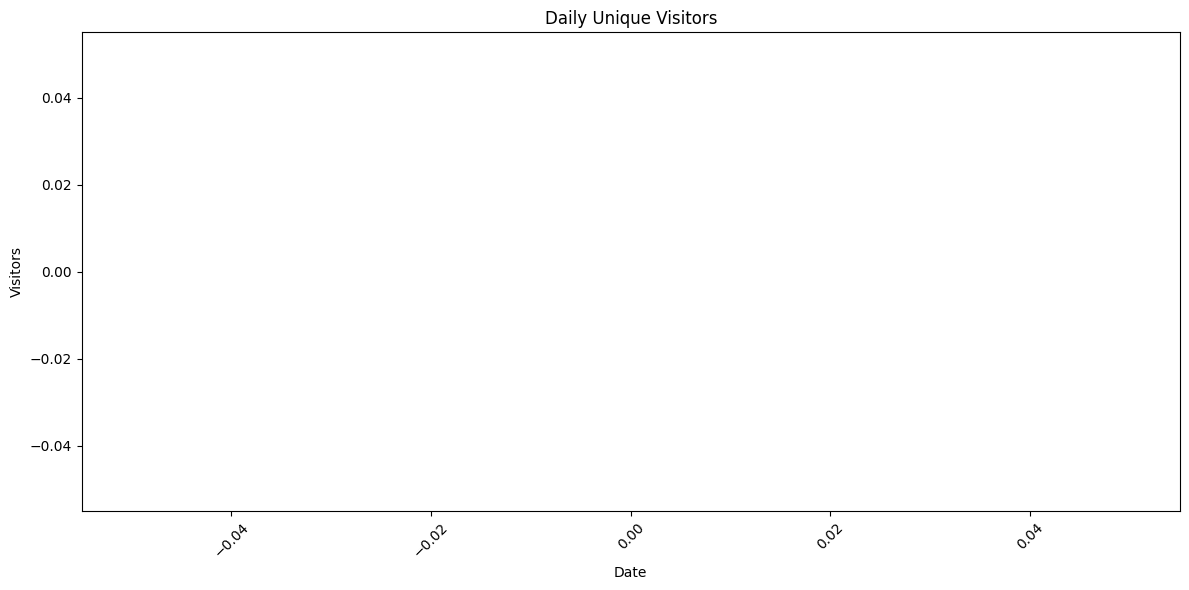

In [7]:
# Convert Spark DataFrame to Pandas for visualization
daily_stats_pd = daily_stats.toPandas()

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(daily_stats_pd['date'], daily_stats_pd['unique_visitors'])
plt.title('Daily Unique Visitors')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data processing using pyspark RDD

This section demonstrates RDD-based data processing, including basic and advanced RDD analysis, and error handling

### Basic RDD analysis

We perform basic RDD transformation such as filtering successful requests and failed requests

In [8]:
!pip install pyspark

In [19]:
from google.colab import files

# This will prompt you to upload a file from your local system
uploaded = files.upload()

# This will display the uploaded file names
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")


Saving apache_logs to apache_logs
Uploaded file: apache_logs


In [20]:
from pyspark import SparkContext
import re

# Initialize Spark Context
sc = SparkContext.getOrCreate()

# Load log file into an RDD
log_file_path = "apache_logs"
log_rdd = sc.textFile(log_file_path)


# Apache Log Regex Pattern
LOG_PATTERN = r'(\d+\.\d+\.\d+\.\d+) - - \[(.*?)\] "(.*?)" (\d{3}) (\d+|-)'

# Function to parse a log line
def parse_log(line):
    match = re.match(LOG_PATTERN, line)
    if match:
        return {
            'ip': match.group(1),
            'timestamp': match.group(2),
            'request': match.group(3),
            'status': match.group(4),
            'size': int(match.group(5)) if match.group(5).isdigit() else 0
        }
    else:
        return None  # Return None for malformed lines

# Parse logs and filter out malformed entries
parsed_rdd = log_rdd.map(parse_log).filter(lambda x: x is not None)

print(parsed_rdd.take(10))  # Inspect the first 10 entries





# Count requests by HTTP method
method_counts = (
    parsed_rdd
    .filter(lambda x: 'request' in x and x['request'])  # Ensure request field exists
    .map(lambda x: (x['request'].split()[0], 1))  # Extract HTTP method
    .reduceByKey(lambda a, b: a + b)  # Count by method
)

print("HTTP Method Counts:", method_counts.collect())


[{'ip': '83.149.9.216', 'timestamp': '17/May/2015:10:05:03 +0000', 'request': 'GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1', 'status': '200', 'size': 203023}, {'ip': '83.149.9.216', 'timestamp': '17/May/2015:10:05:43 +0000', 'request': 'GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1', 'status': '200', 'size': 171717}, {'ip': '83.149.9.216', 'timestamp': '17/May/2015:10:05:47 +0000', 'request': 'GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1', 'status': '200', 'size': 26185}, {'ip': '83.149.9.216', 'timestamp': '17/May/2015:10:05:12 +0000', 'request': 'GET /presentations/logstash-monitorama-2013/plugin/zoom-js/zoom.js HTTP/1.1', 'status': '200', 'size': 7697}, {'ip': '83.149.9.216', 'timestamp': '17/May/2015:10:05:07 +0000', 'request': 'GET /presentations/logstash-monitorama-2013/plugin/notes/notes.js HTTP/1.1', 'status': '200', 'size': 2892}, {'ip': '83.149.9.216', 'timestamp': '17/

In [21]:
from datetime import datetime

# Extract hour from timestamp
def extract_hour(timestamp):
    dt = datetime.strptime(timestamp, "%d/%b/%Y:%H:%M:%S %z")
    return dt.strftime("%Y-%m-%d %H:00")

# Count visits per hour per IP
hourly_visits = (
    parsed_rdd
    .map(lambda x: ((extract_hour(x['timestamp']), x['ip']), 1))  # Create (hour, IP) key
    .reduceByKey(lambda a, b: a + b)  # Count visits
)

print("Hourly Visit Counts per IP:", hourly_visits.collect())


Hourly Visit Counts per IP: [(('2015-05-17 10:00', '24.236.252.67'), 1), (('2015-05-17 10:00', '93.114.45.13'), 6), (('2015-05-17 10:00', '66.249.73.135'), 4), (('2015-05-17 10:00', '50.16.19.13'), 1), (('2015-05-17 10:00', '66.249.73.185'), 3), (('2015-05-17 10:00', '50.150.204.184'), 1), (('2015-05-17 10:00', '207.241.237.225'), 1), (('2015-05-17 10:00', '200.49.190.101'), 3), (('2015-05-17 10:00', '91.177.205.119'), 6), (('2015-05-17 10:00', '207.241.237.101'), 1), (('2015-05-17 10:00', '87.169.99.232'), 1), (('2015-05-17 10:00', '209.85.238.199'), 2), (('2015-05-17 10:00', '81.220.24.207'), 6), (('2015-05-17 11:00', '66.249.73.135'), 7), (('2015-05-17 11:00', '74.125.40.20'), 1), (('2015-05-17 11:00', '108.174.55.234'), 1), (('2015-05-17 11:00', '121.107.188.202'), 1), (('2015-05-17 11:00', '198.46.149.143'), 2), (('2015-05-17 11:00', '50.16.19.13'), 1), (('2015-05-17 11:00', '50.180.79.170'), 1), (('2015-05-17 11:00', '105.235.130.196'), 6), (('2015-05-17 11:00', '54.255.13.204'),

In [22]:
# Count visits per URL
top_urls = (
    parsed_rdd
    .map(lambda x: (x['request'].split()[1], 1))  # Extract URL
    .reduceByKey(lambda a, b: a + b)  # Count by URL
    .sortBy(lambda x: x[1], ascending=False)  # Sort by count (descending)
    .take(10)  # Get top 10
)

print("Top 10 Visited URLs:", top_urls)


Top 10 Visited URLs: [('/favicon.ico', 807), ('/style2.css', 546), ('/reset.css', 538), ('/images/jordan-80.png', 533), ('/images/web/2009/banner.png', 516), ('/blog/tags/puppet?flav=rss20', 488), ('/projects/xdotool/', 224), ('/?flav=rss20', 217), ('/', 197), ('/robots.txt', 180)]


In [23]:
# Count failed requests by status code
failed_requests = (
    parsed_rdd
    .filter(lambda x: int(x['status']) >= 400)  # Filter failed requests
    .map(lambda x: (x['status'], 1))  # Create (status code, 1) pairs
    .reduceByKey(lambda a, b: a + b)  # Count by status code
)

print("Failed Requests by Status Code:", failed_requests.collect())


Failed Requests by Status Code: [('404', 213), ('500', 3), ('403', 2), ('416', 2)]
